# 1. 환경설정

내용
- 파이토치 사용
- 패션, 화장품, 가전, IT기기, 생활 5가지 분야에 대한 쇼핑몰과 SNS 리뷰
- 쇼핑몰 리뷰 데이터 감성 분석
- Full Fine-Tuning & PEFT 활용 후 차이점 확인

데이터
- JSON 파일 하나에 여러 개의 리뷰가 포함
- RawText: 리뷰 텍스트
- GeneralPolarity: 긍부정 라벨(부정=-1, 중립=0, 긍정=1)

가이드
- 감성 분석 모델을 학습시키기 위한 형식으로 적절하게 변환
- 전체 데이터를 학습 데이터와 테스트 데이터로 분할
- transformers 라이브러리로 Full Fine-Tuning
- peft 라이브러리로 PEFT
- Full Fine-Tuning과 PEFT 방식 비교 분석 및 제출


In [46]:
import sys
if 'google.cloud' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.projects.autoconfig as config
    config.directory('./projects/lab/250709-250714_review-sentiment-analysis/review-sentiment-analysis')
    config.font('./NanumGothic.ttf')

!ls -al



import pandas as pd
import json
from glob import glob
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/develop/projects/lab/250709-250714_review-sentiment-analysis/review-sentiment-analysis
./NanumGothic.ttf 폰트 등록 완료
total 39117
-rw------- 1 root root   375086 Jul 10 16:01 01.ipynb
drwx------ 4 root root     4096 Jul 10 15:07 data
-rw------- 1 root root 34970414 Jul 10 06:03 data.zip
drwx------ 2 root root     4096 Jul 10 06:25 .git
-rw------- 1 root root     4895 Jul 10 06:25 .gitignore
-rw------- 1 root root  4691820 Jun 21 07:09 NanumGothic.ttf
drwx------ 2 root root     4096 Jul 10 08:16 processed_data
-rw------- 1 root root       27 Jul 10 06:25 README.md


# 2. EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184525 entries, 0 to 184524
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      184525 non-null  object
 1   source    184525 non-null  object
 2   domain    184525 non-null  object
 3   category  184525 non-null  object
 4   label     184525 non-null  int64 
 5   length    184525 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 8.4+ MB
None


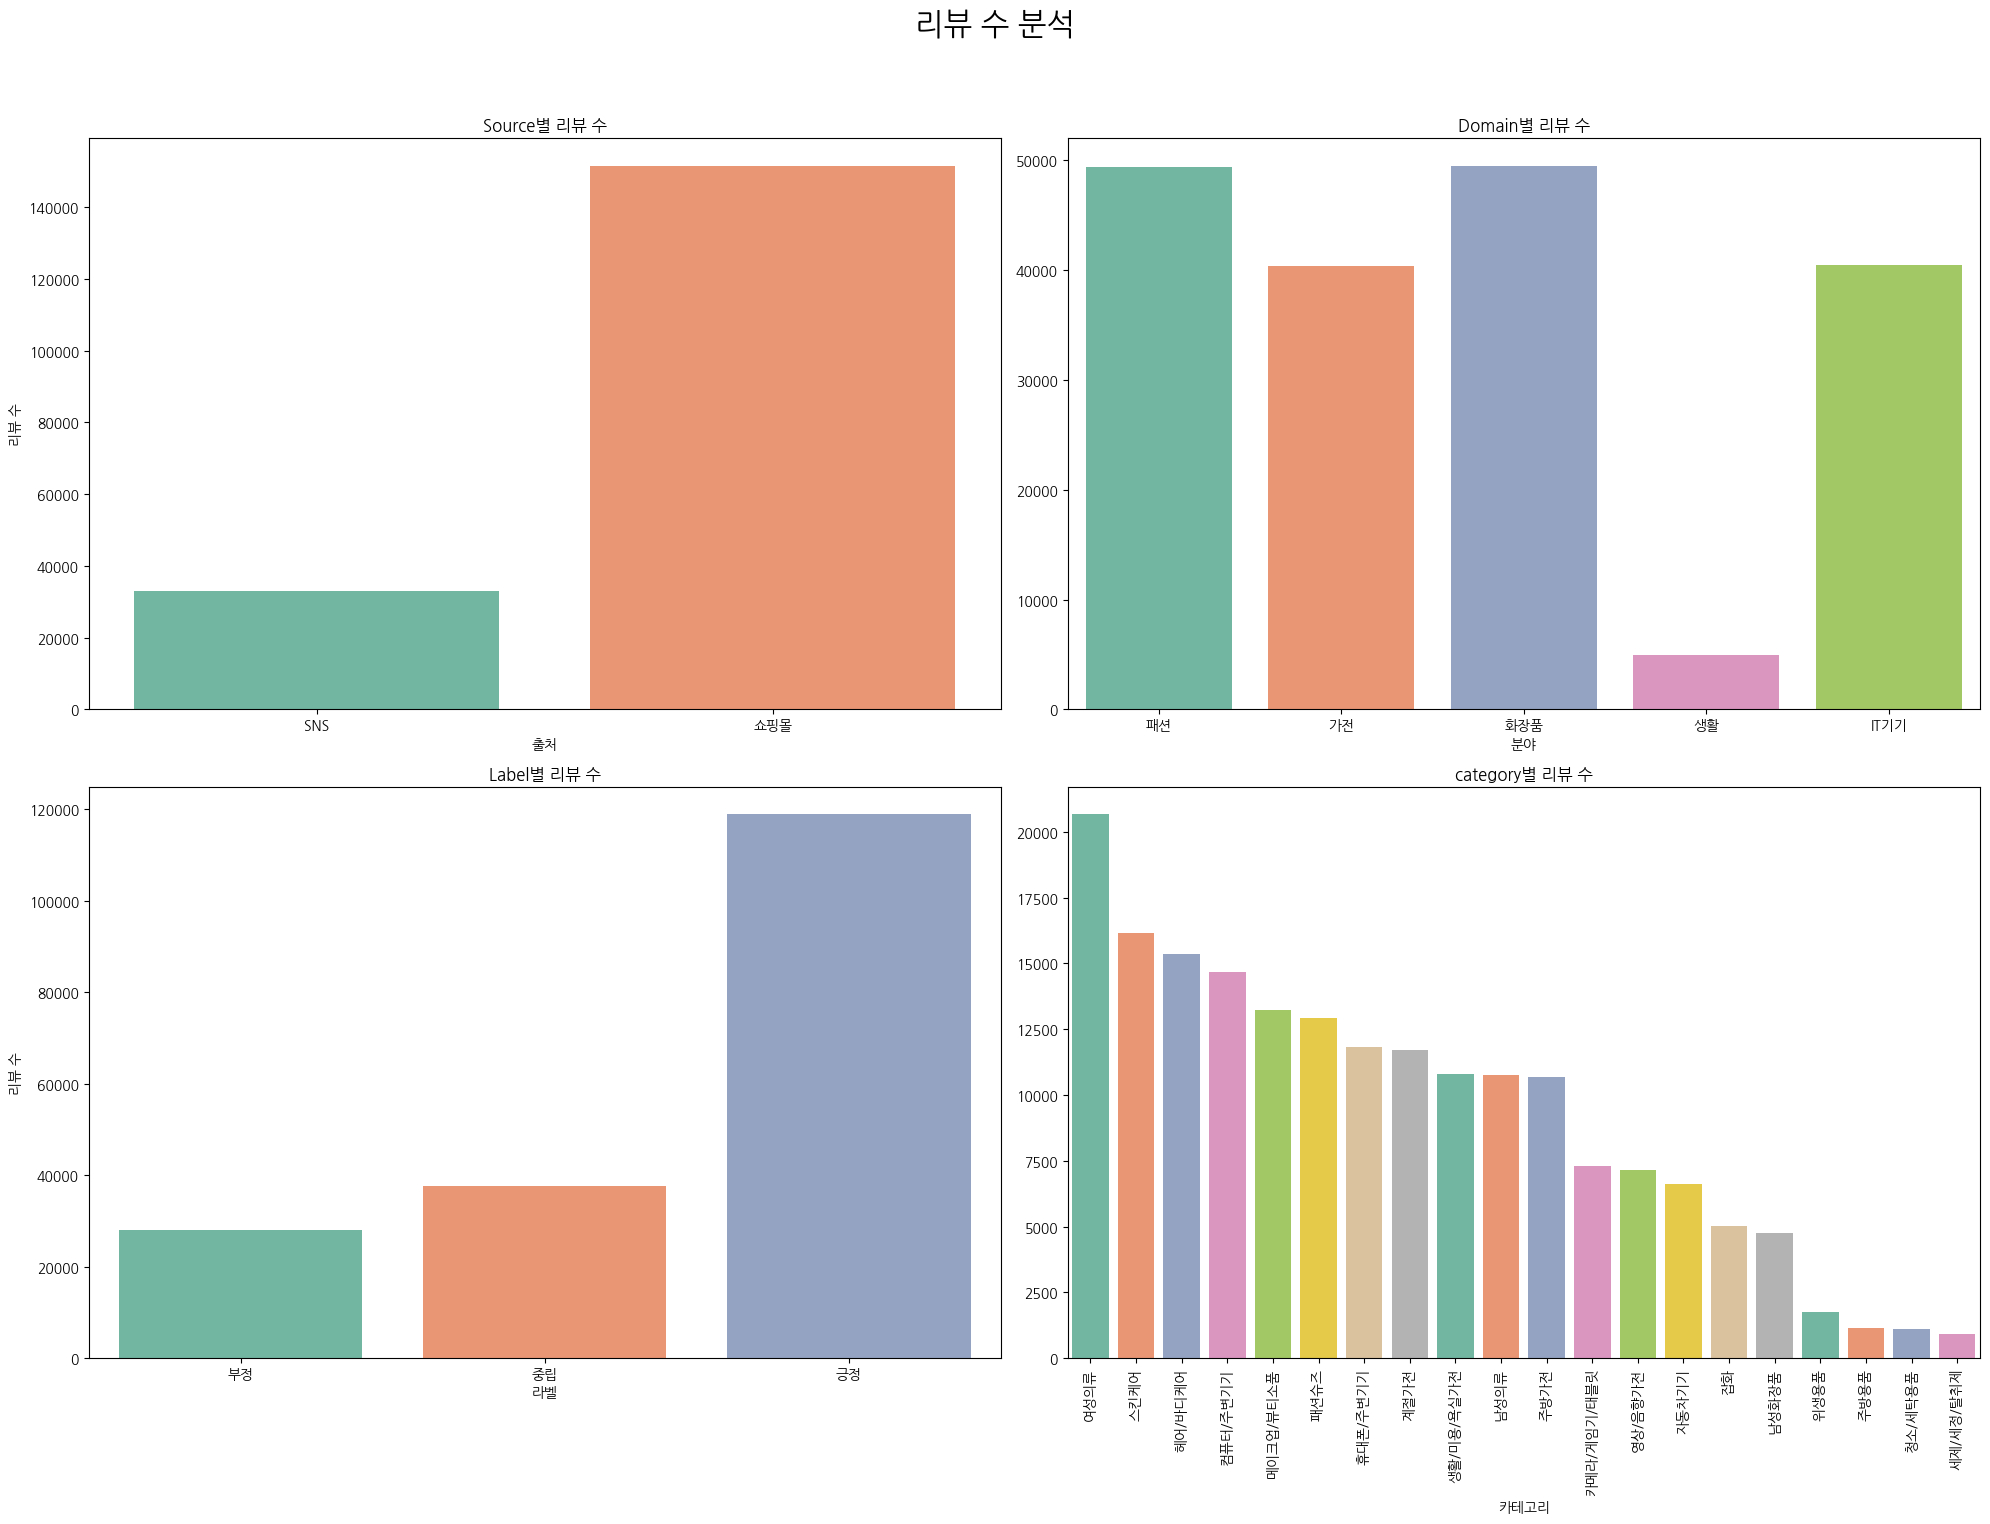

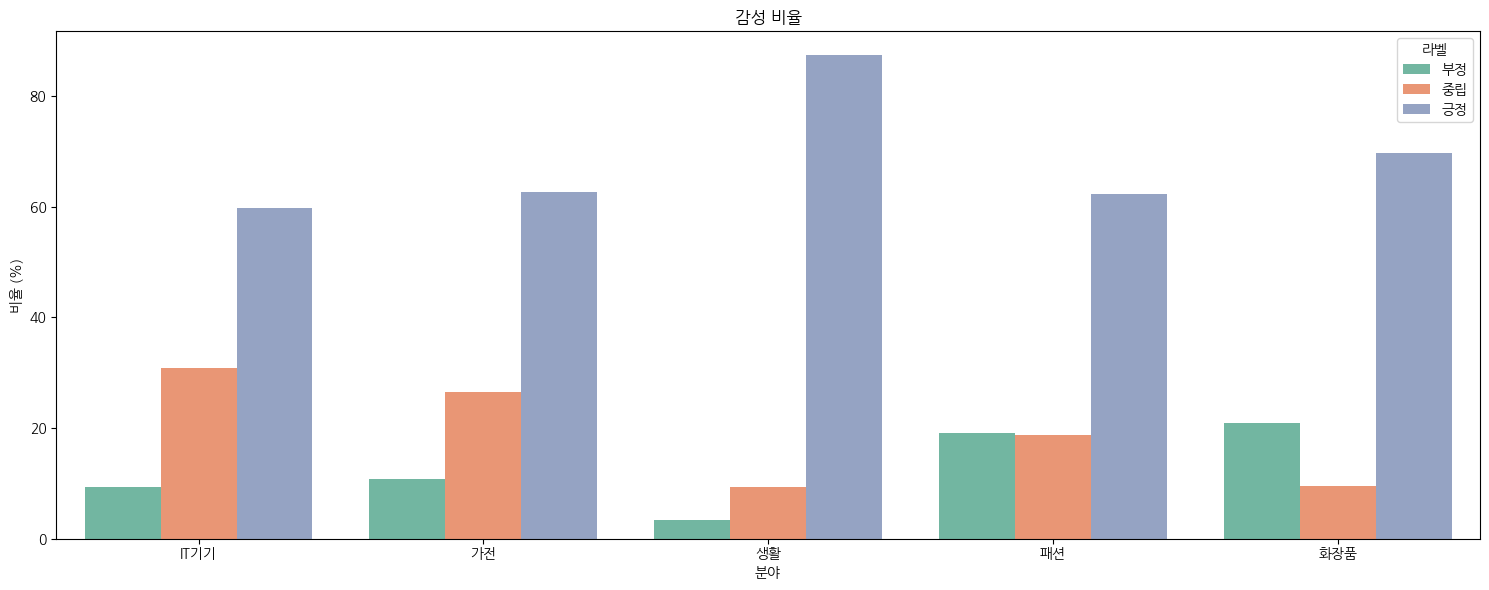

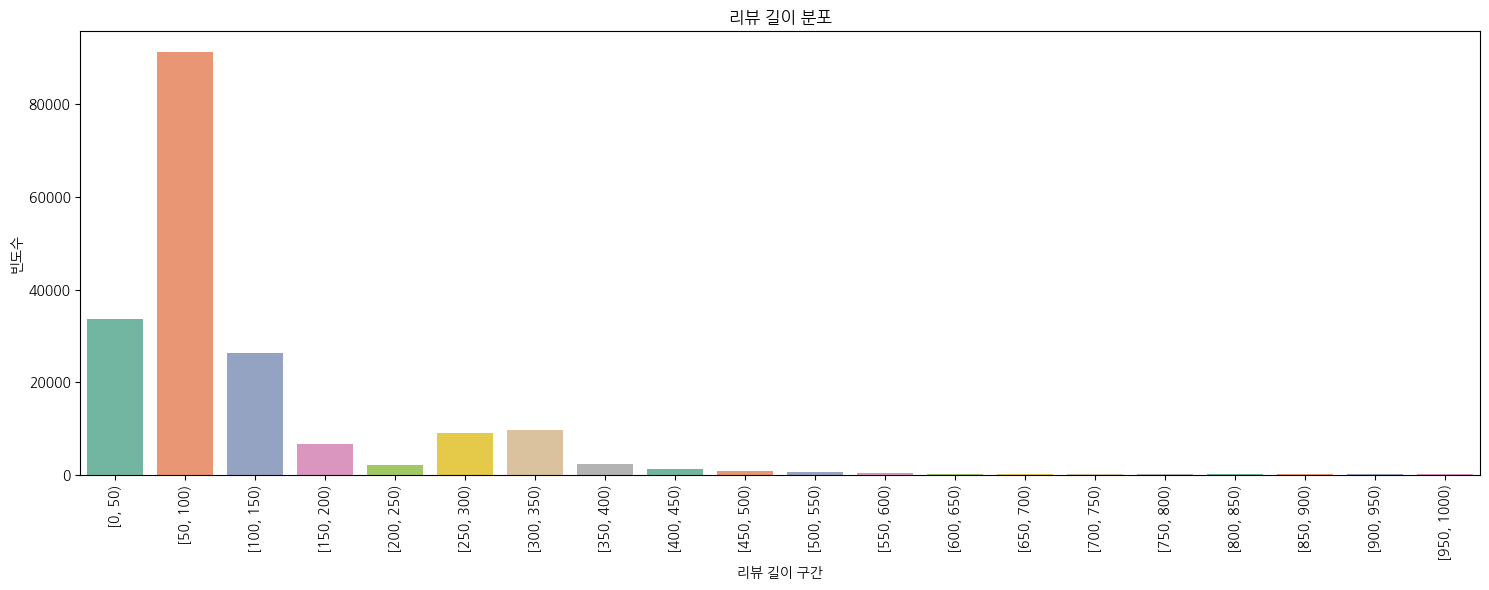

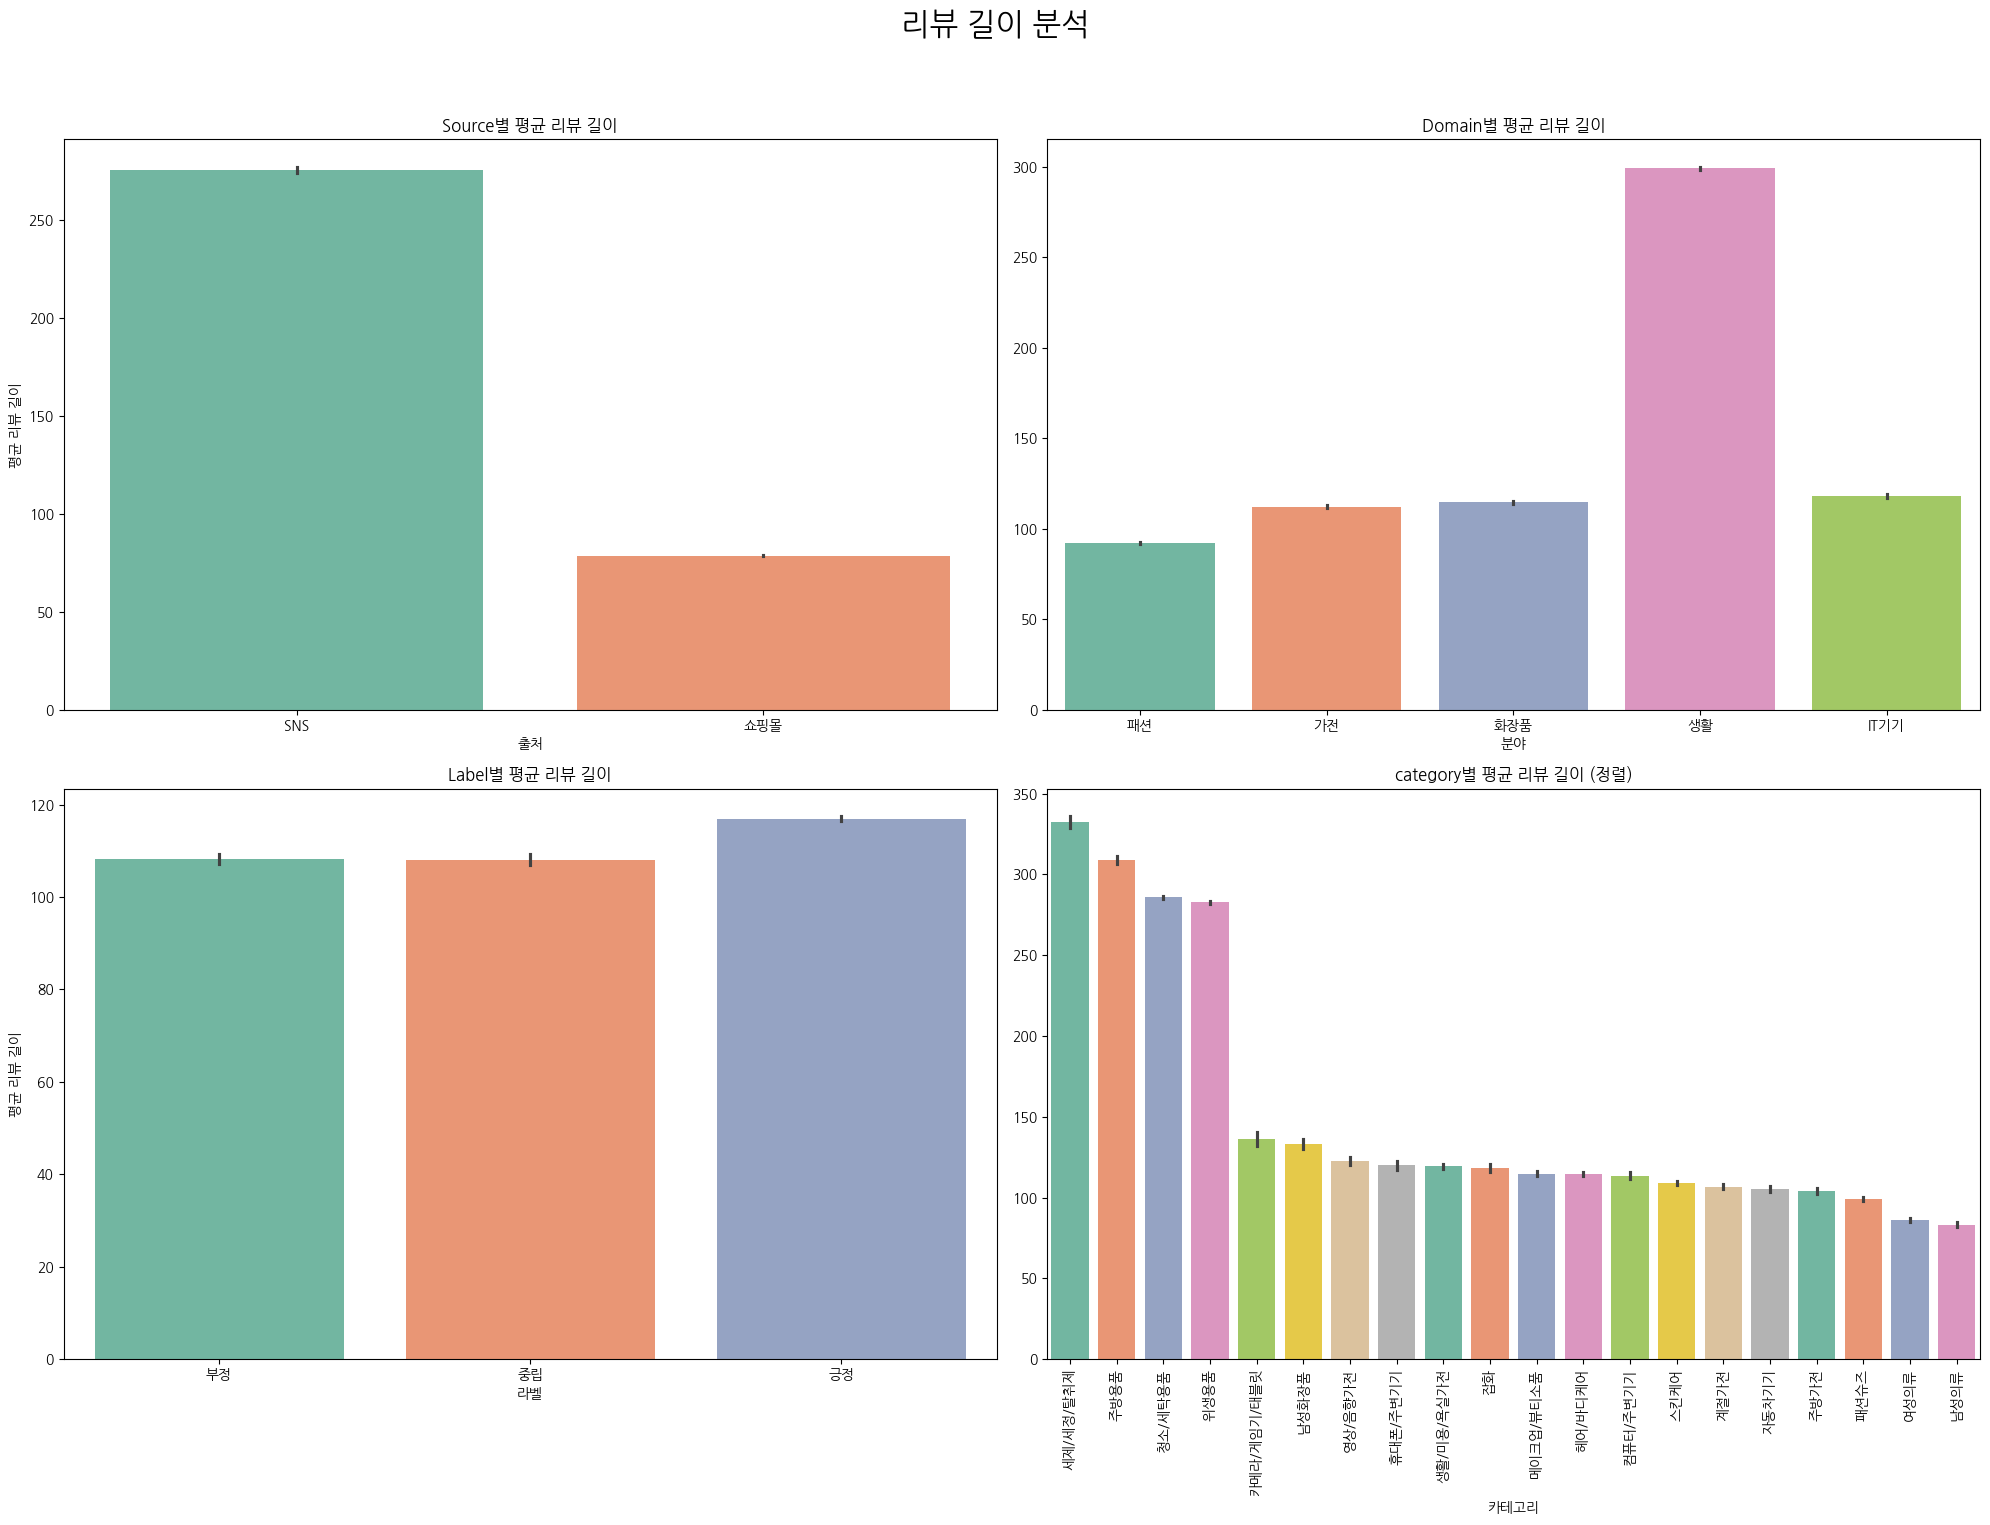

In [48]:
""" JSON 파일 로드 및 CSV 변환 함수 """
def load_json(load_dir, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    target_columns = {
        'RawText'         : 'text',
        'Source'          : 'source',
        'Domain'          : 'domain',
        'MainCategory'    : 'category',
        'GeneralPolarity' : 'label',
        'Syllable'        : 'length'
    }

    all_reviews = []

    for dir in load_dir:
        json_files = glob(os.path.join(dir, '**', '*.json'), recursive=True)

        for file_path in tqdm(json_files, desc=f"Loading '{dir}'"):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

                for review in data:
                    d = {new: review.get(old) for old, new in target_columns.items() if old in review}
                    all_reviews.append(d)

    df = pd.DataFrame(all_reviews)

    df.dropna(inplace=True)
    df['label'] = pd.to_numeric(df['label']).apply(lambda x: int(x) + 1)
    df['length'] = pd.to_numeric(df['length'])

    df.to_csv(os.path.join(save_dir, 'reviews.csv'), index=False, encoding='utf-8-sig')

    return df


""" CSV 저장 """
# load_json(['./data/SNS/', './data/쇼핑몰/'], './data')


""" CSV 로드 """
df = pd.read_csv('./data/reviews.csv')


""" 정보 확인 """
print(df.info())


""" 리뷰 수 분석 """
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('리뷰 수 분석', fontsize=22)

# Source별 리뷰 수
sns.countplot(ax=axes[0, 0], x='source', data=df, palette='Set2')
axes[0, 0].set_title('Source별 리뷰 수')
axes[0, 0].set_xlabel('출처')
axes[0, 0].set_ylabel('리뷰 수')

# Domain별 리뷰 수
sns.countplot(ax=axes[0, 1], x='domain', data=df, palette='Set2')
axes[0, 1].set_title('Domain별 리뷰 수')
axes[0, 1].set_xlabel('분야')
axes[0, 1].set_ylabel('')

# Label별 리뷰 수
sns.countplot(ax=axes[1, 0], x='label', data=df, palette='Set2')
axes[1, 0].set_title('Label별 리뷰 수')
axes[1, 0].set_xlabel('라벨')
axes[1, 0].set_ylabel('리뷰 수')
axes[1, 0].set_xticks(ticks=[0, 1, 2])
axes[1, 0].set_xticklabels(['부정', '중립', '긍정'])

# Category별 리뷰 수
top_20_categories = df['category'].value_counts().head(20).index
sns.countplot(ax=axes[1, 1], x='category', data=df, order=top_20_categories, palette='Set2')
axes[1, 1].set_title('category별 리뷰 수')
axes[1, 1].set_xlabel('카테고리')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


""" 감성 비율 """
domain_label_ratio = df.groupby('domain')['label'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(ax=ax, x='domain', y='percent', hue='label', data=domain_label_ratio, palette='Set2')
ax.set_title('감성 비율')
ax.set_xlabel('분야')
ax.set_ylabel('비율 (%)')
ax.legend(handles=ax.get_legend_handles_labels()[0], title='라벨', labels=['부정', '중립', '긍정'])
plt.tight_layout()
plt.show()


""" 리뷰 길이 분포 """
max_len = df['length'].max()
step = 50
bin_edges = np.arange(0, max_len + step, step)
bins = pd.cut(df['length'], bins=bin_edges, right=False)
binned_counts = bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(ax=ax, x=binned_counts.index.astype(str), y=binned_counts.values, palette='Set2')
ax.set_title('리뷰 길이 분포')
ax.set_xlabel('리뷰 길이 구간')
ax.set_ylabel('빈도수')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


""" 리뷰 길이 분석 """
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('리뷰 길이 분석', fontsize=22)

# Source별 평균 길이
sns.barplot(ax=axes[0, 0], x='source', y='length', data=df, palette='Set2')
axes[0, 0].set_title('Source별 평균 리뷰 길이')
axes[0, 0].set_xlabel('출처')
axes[0, 0].set_ylabel('평균 리뷰 길이')

# Domain별 평균 길이
sns.barplot(ax=axes[0, 1], x='domain', y='length', data=df, palette='Set2')
axes[0, 1].set_title('Domain별 평균 리뷰 길이')
axes[0, 1].set_xlabel('분야')
axes[0, 1].set_ylabel('')

# Label별 평균 길이
sns.barplot(ax=axes[1, 0], x='label', y='length', data=df, palette='Set2')
axes[1, 0].set_title('Label별 평균 리뷰 길이')
axes[1, 0].set_xlabel('라벨')
axes[1, 0].set_ylabel('평균 리뷰 길이')
axes[1, 0].set_xticklabels(['부정', '중립', '긍정'])

# Category별 평균 길이
top_20_categories = df['category'].value_counts().head(20).index
top_20_df = df[df['category'].isin(top_20_categories)]
sorted_order = top_20_df.groupby('category')['length'].mean().sort_values(ascending=False).index
sns.barplot(ax=axes[1, 1], x='category', y='length', data=top_20_df, order=sorted_order, palette='Set2')
axes[1, 1].set_title('category별 평균 리뷰 길이 (정렬)')
axes[1, 1].set_xlabel('카테고리')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
`

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BitsAndBytesConfig

from peft import get_peft_model, LoraConfig, TaskType


# QLoRA에 필요한 라이브러리가 설치되어 있는지 확인
try:
    import bitsandbytes
    import accelerate
except ImportError:
    print("QLoRA를 위해 bitsandbytes와 accelerate를 설치합니다.")
    # !pip install bitsandbytes accelerate

""" 1. 데이터 준비 (학습/테스트 분리 및 토크나이징) """
# --- CSV 로드 ---
df = pd.read_csv('./data/reviews.csv')


# --- 학습/테스트 데이터 분리 ---
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


# --- 모델 및 토크나이저 설정 ---
MODEL_NAME = 'beomi/kc-electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# --- 토크나이징 함수 정의 및 적용 ---
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 불필요한 컬럼 제거
tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in ['input_ids', 'attention_mask', 'label']])
tokenized_test = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in ['input_ids', 'attention_mask', 'label']])


# --- 평가 지표 계산 함수 ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


""" 2. Full Fine-Tuning 학습 """
print("--- 🚀 Full Fine-Tuning 시작 ---")
full_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

full_training_args = TrainingArguments(
    output_dir='./results/full_model',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

full_trainer = Trainer(
    model=full_model,
    args=full_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)
full_trainer.train()


""" 3. PEFT (LoRA) 학습 """
print("\n\n--- ⚡ PEFT (LoRA) 시작 ---")
lora_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.1, target_modules=["query", "key", "value"]
)
lora_model_with_peft = get_peft_model(lora_model, lora_config)

lora_training_args = TrainingArguments(
    output_dir='./results/lora_model',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

lora_trainer = Trainer(
    model=lora_model_with_peft,
    args=lora_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)
lora_trainer.train()


""" 4. PEFT (QLoRA) 학습 """
print("\n\n--- ✨ PEFT (QLoRA) 시작 ---")
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)
qlora_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, quantization_config=quantization_config
)
qlora_model_with_peft = get_peft_model(qlora_model, lora_config)

qlora_training_args = TrainingArguments(
    output_dir='./results/qlora_model',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

qlora_trainer = Trainer(
    model=qlora_model_with_peft,
    args=qlora_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)
qlora_trainer.train()


""" 5. 모델 평가 """
print("\n\n--- 🧪 모델별 최종 평가 ---")
# 테스트 데이터셋으로 각 모델의 최종 성능을 평가
full_eval_results = full_trainer.evaluate(tokenized_test)
lora_eval_results = lora_trainer.evaluate(tokenized_test)
qlora_eval_results = qlora_trainer.evaluate(tokenized_test)

print(f"\nFull Fine-Tuning 평가 결과: {full_eval_results}")
print(f"LoRA 평가 결과: {lora_eval_results}")
print(f"QLoRA 평가 결과: {qlora_eval_results}")


""" 6. 새로운 텍스트에 대한 예측 """
print("\n\n--- 🔮 새로운 텍스트 예측 ---")

# 예측을 위한 함수 정의
def predict(text, model, tokenizer):
    # 라벨 정의
    label_map = {0: "부정", 1: "중립", 2: "긍정"}

    # 모델과 같은 디바이스로 입력 데이터 이동
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(model.device)

    # 그래디언트 계산 비활성화
    with torch.no_grad():
        outputs = model(**inputs)

    # 가장 높은 확률의 라벨 예측
    predictions = torch.argmax(outputs.logits, dim=-1)

    # 예측된 숫자 라벨을 텍스트 라벨로 변환하여 반환
    return label_map.get(predictions.item(), "알 수 없음")

# 테스트할 새로운 문장들
new_texts = [
    "디자인은 괜찮은데 배송이 너무 느렸어요.",
    "이 식당 정말 추천합니다! 인생 맛집이에요.",
    "솔직히 기대했던 것보다는 좀 별로였음.",
    "친구가 부산 광안리에서 맛있는 회를 사줬어."
]

# 각 모델별로 예측 수행 및 결과 출력
for text in new_texts:
    print(f"\n입력 텍스트: '{text}'")
    print(f"  - Full Fine-Tuning 예측: {predict(text, full_model, tokenizer)}")
    print(f"  - LoRA 예측: {predict(text, lora_model_with_peft, tokenizer)}")
    print(f"  - QLoRA 예측: {predict(text, qlora_model_with_peft, tokenizer)}")